# Preprocessing and Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import mlflow
import mlflow.sklearn 
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle as pkl
sns.set()


In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("home-credit-default-risk")

<Experiment: artifact_location='file:///d:/mokon/Documents/MlopsZoomcamp_project_data/home-credit-default-risk/mlruns/1', creation_time=1752425261672, experiment_id='1', last_update_time=1752425261672, lifecycle_stage='active', name='home-credit-default-risk', tags={}>

In [3]:
def read_data(path):
    df = pd.read_csv(path)
    return df

def preprocess_data(df):
    df = df[df["AMT_INCOME_TOTAL"] < df["AMT_INCOME_TOTAL"].quantile(0.95)]
    df["BUREAU"] = df["SK_ID_BUREAU"].notna().astype(int)
    df.drop( ["SK_ID_CURR","SK_ID_BUREAU"], inplace = True, axis = 1) 
    return df

In [4]:
def fill_null_values(df):
    
    
    
    missing_one = df.isnull().sum()
    missing_one = missing_one[missing_one == 1]
    common_missing = set(df[df[missing_one.index[0]].isnull()].index)
    for col in missing_one.index[1:]:
        common_missing &= set(df[df[col].isnull()].index)
        
    df.drop(list(common_missing)[0], inplace = True)
    
    df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(df["AMT_ANNUITY"].median())
    
    for target in df["TARGET"].unique():
        mask = (df["TARGET"] == target) & (df["OCCUPATION_TYPE"].isna())
        n_missing = mask.sum()
        probs = df.loc[
            (df["TARGET"] == target) & (df["OCCUPATION_TYPE"].notna()),"OCCUPATION_TYPE"
        ].value_counts(normalize = True)
        imputed_values = np.random.choice(probs.index, size = n_missing, p = probs.values)
        df.loc[mask, "OCCUPATION_TYPE"] = imputed_values
    
    df["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].fillna(df["EXT_SOURCE_2"].median())
    
    df["CREDIT_ACTIVE"] = df["CREDIT_ACTIVE"].fillna("NO_BUREAU")
    
    df["CREDIT_DAY_OVERDUE_BIN"] = pd.cut(
        df["CREDIT_DAY_OVERDUE"],
        bins = [-1,0,7,30,365,float("inf")],
        labels = [0,1,2,3,4]
)

    df["CREDIT_DAY_OVERDUE_BIN"] = df["CREDIT_DAY_OVERDUE_BIN"].cat.add_categories(["No_Bureau"])
    df["CREDIT_DAY_OVERDUE_BIN"] = df["CREDIT_DAY_OVERDUE_BIN"].fillna("No_Bureau")
    
    df.drop(["CREDIT_DAY_OVERDUE"], axis = 1, inplace = True)
    
    df["DAYS_CREDIT"] = df["DAYS_CREDIT"].fillna(9999)
    
    df["LOG_AMT_CREDIT_SUM"] = np.log1p(df["AMT_CREDIT_SUM"]) 
    
    lower = df["LOG_AMT_CREDIT_SUM"].quantile(0.01)
    upper = df["LOG_AMT_CREDIT_SUM"].quantile(0.99)
    df["LOG_AMT_CREDIT_SUM_CLIPPED"] = df["LOG_AMT_CREDIT_SUM"].clip(lower, upper)
    
    df["LOG_AMT_CREDIT_SUM_CLIPPED"] = df["LOG_AMT_CREDIT_SUM_CLIPPED"].fillna(-1)
    
    df.drop(["AMT_CREDIT_SUM","LOG_AMT_CREDIT_SUM"], axis = 1, inplace = True)
    
    df["CNT_FAM_MEMBERS"] = df["CNT_FAM_MEMBERS"].fillna(df["CNT_FAM_MEMBERS"].median())
    
    return df
    

In [5]:
path = "MLops_Zoomcamp_project_table_joins.csv"
df = fill_null_values(preprocess_data(read_data(path)))
df.head()



,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,CREDIT_ACTIVE,DAYS_CREDIT,BUREAU,CREDIT_DAY_OVERDUE_BIN,LOG_AMT_CREDIT_SUM_CLIPPED
0,0,Cash loans,M,Y,N,0,76500.0,454500.0,14661.0,Working,...,0.0,0.0,0.0,0.0,0.0,Closed,-1703.0,1,0,10.596447
1,1,Revolving loans,M,Y,N,1,270000.0,810000.0,40500.0,Working,...,0.0,0.0,0.0,0.0,0.0,Active,-449.0,1,0,14.063884
2,0,Cash loans,F,N,N,0,99000.0,364896.0,13653.0,Commercial associate,...,0.0,0.0,0.0,0.0,0.0,Active,-409.0,1,0,11.630717
3,0,Cash loans,F,N,N,0,112500.0,199008.0,19683.0,Pensioner,...,0.0,0.0,0.0,0.0,0.0,Closed,-2653.0,1,0,10.984996
4,0,Cash loans,F,N,Y,0,112500.0,225000.0,21919.5,Working,...,0.0,0.0,0.0,0.0,0.0,Closed,-1779.0,1,0,11.391447


In [6]:
pd.set_option('display.max_columns', None)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,FLAG_EMAIL,EXT_SOURCE_2,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,CREDIT_ACTIVE,DAYS_CREDIT,BUREAU,CREDIT_DAY_OVERDUE_BIN,LOG_AMT_CREDIT_SUM_CLIPPED
0,0,Cash loans,M,Y,N,0,76500.0,454500.0,14661.0,Working,Secondary / secondary special,Married,House / apartment,-12282.0,-778.0,1.0,1.0,Sales staff,2.0,0.0,0.705947,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Closed,-1703.0,1,0,10.596447
1,1,Revolving loans,M,Y,N,1,270000.0,810000.0,40500.0,Working,Secondary / secondary special,Married,House / apartment,-11353.0,-651.0,1.0,1.0,Security staff,3.0,0.0,0.335981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Active,-449.0,1,0,14.063884
2,0,Cash loans,F,N,N,0,99000.0,364896.0,13653.0,Commercial associate,Higher education,Single / not married,House / apartment,-11156.0,-890.0,1.0,1.0,Laborers,1.0,0.0,0.579265,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Active,-409.0,1,0,11.630717
3,0,Cash loans,F,N,N,0,112500.0,199008.0,19683.0,Pensioner,Secondary / secondary special,Married,House / apartment,-18909.0,365243.0,1.0,1.0,Managers,2.0,0.0,0.667982,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Closed,-2653.0,1,0,10.984996
4,0,Cash loans,F,N,Y,0,112500.0,225000.0,21919.5,Working,Higher education,Single / not married,House / apartment,-18047.0,-732.0,1.0,1.0,Core staff,1.0,0.0,0.549847,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Closed,-1779.0,1,0,11.391447


In [7]:
yes_no = ["FLAG_OWN_CAR","FLAG_OWN_REALTY"] 
cat_columns = []
for col in df.columns:
    if (df[col].dtype != "float64" and df[col].dtype != "int64") and df[col].dtype != "int32":
        cat_columns.append(col)
        
def dummy_encode(df, cat_columns, yes_no):
    for col in yes_no:
        df[col] = df[col].map({"Y":1,"N":0})
         
    df = pd.get_dummies(df, columns = cat_columns, drop_first = True).astype(int)
    
    return df

In [8]:
df = dummy_encode(df, cat_columns, yes_no)
df.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,FLAG_EMAIL,EXT_SOURCE_2,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,DAYS_CREDIT,BUREAU,LOG_AMT_CREDIT_SUM_CLIPPED,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_1,FLAG_OWN_REALTY_1,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_NO_BUREAU,CREDIT_ACTIVE_Sold,CREDIT_DAY_OVERDUE_BIN_1,CREDIT_DAY_OVERDUE_BIN_2,CREDIT_DAY_OVERDUE_BIN_3,CREDIT_DAY_OVERDUE_BIN_4,CREDIT_DAY_OVERDUE_BIN_No_Bureau
0,0,0,76500,454500,14661,-12282,-778,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1703,1,10,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,270000,810000,40500,-11353,-651,1,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-449,1,14,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,99000,364896,13653,-11156,-890,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-409,1,11,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,112500,199008,19683,-18909,365243,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2653,1,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,112500,225000,21919,-18047,-732,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1779,1,11,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
df.shape

(928436, 87)

### Let's separate the variables

In [10]:
X = df.drop(["TARGET"], axis = 1)
Y = df["TARGET"]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

2025/07/27 20:16:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


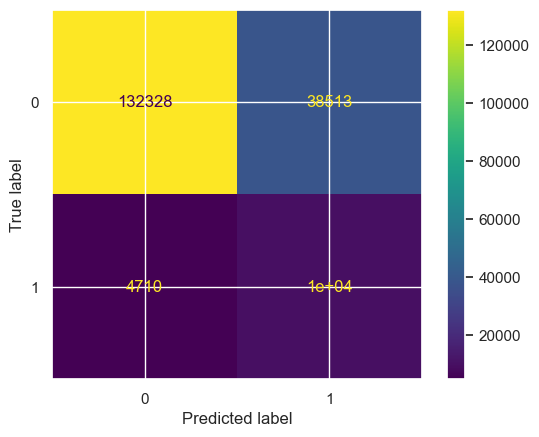

In [12]:
with mlflow.start_run():
    params = {
        "n_estimators": 100,
        "max_depth": 15,
        "min_samples_split": 10,
        "class_weight":"balanced"
    }
    mlflow.log_params(params) 
    tree = RandomForestClassifier(**params)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.sklearn.log_model(tree, "model")

In [13]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.77      0.86    170841
           1       0.21      0.68      0.32     14847

    accuracy                           0.77    185688
   macro avg       0.59      0.73      0.59    185688
weighted avg       0.91      0.77      0.82    185688



### Let's check the feature importance

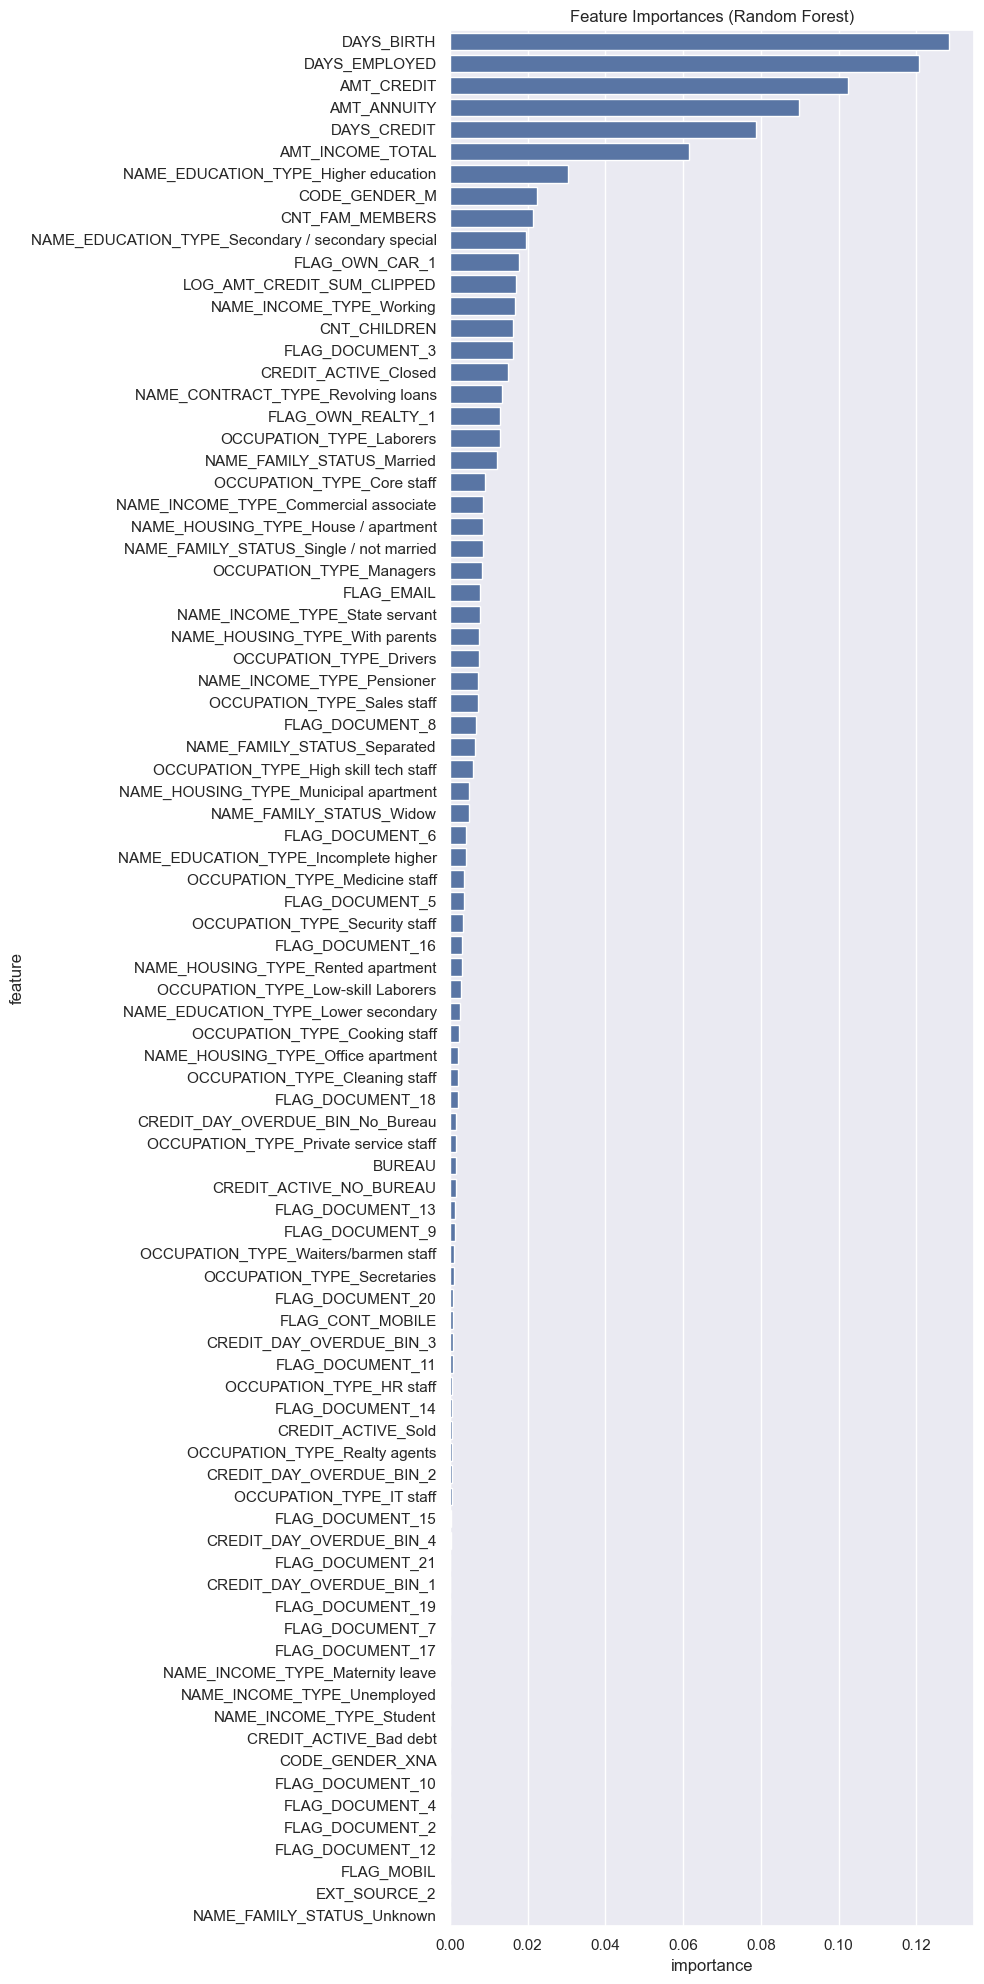

In [14]:
importances = tree.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 20))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df
)
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [15]:
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]  

print(scale_pos_weight)

11.646393788735272


c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/07/27 20:17:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


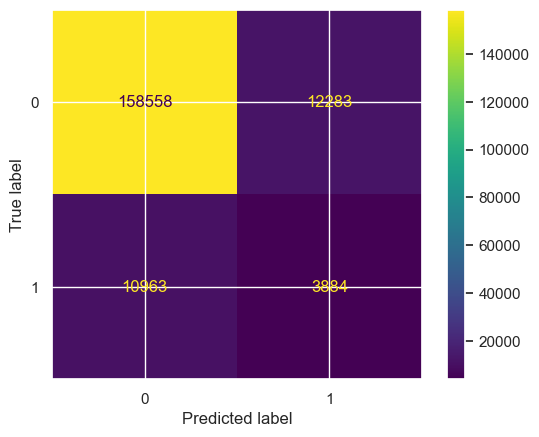

In [16]:
mlflow.set_experiment("xgboost-credit-default")
with mlflow.start_run():
        xgb_params = {
        "n_estimators": 200,
        "max_depth": 6,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "scale_pos_weight": 6,
        "use_label_encoder": False,
        "eval_metric" : 'aucpr',
        "min_child_weight": 5,
        "gamma": 1,
        "reg_alpha": 0.5,
        "reg_lambda": 1.0
    }
        mlflow.log_params(xgb_params)
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(x_train, y_train)
        y_pred = xgb_model.predict(x_test)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        mlflow.log_metric("accuracy", report["accuracy"])
        mlflow.log_metric("f1_score_class_1", report["1"]["f1-score"])
        mlflow.log_metric("recall_class_1", report["1"]["recall"])
        mlflow.log_metric("precision_class_1", report["1"]["precision"])
        
        cm = confusion_matrix(y_test,y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        mlflow.sklearn.log_model(xgb_model, "xgb_model")

In [17]:
from sklearn.metrics import (
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

 Best Threshold for F1: 0.4387
 Best F1 Score: 0.2763

 Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90    170841
           1       0.21      0.42      0.28     14847

    accuracy                           0.82    185688
   macro avg       0.58      0.64      0.59    185688
weighted avg       0.89      0.82      0.85    185688



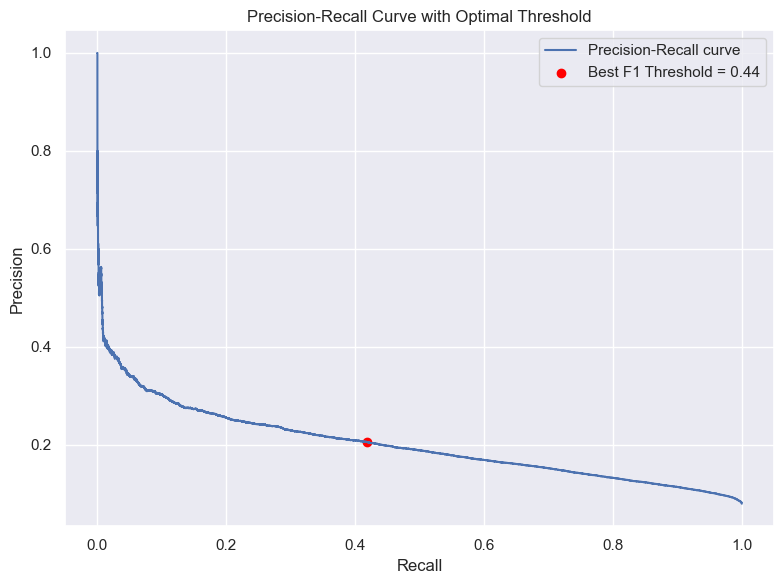

In [18]:
y_proba = xgb_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f" Best Threshold for F1: {best_threshold:.4f}")
print(f" Best F1 Score: {f1_scores[best_idx]:.4f}")

# Predict using best threshold
y_pred_opt = (y_proba > best_threshold).astype(int)

# Show new classification report
print("\n Classification Report at Best Threshold:")
print(classification_report(y_test, y_pred_opt))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Best F1 Threshold = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mlflow.log_metric("best_threshold", best_threshold)
mlflow.log_metric("f1_score_best_threshold", f1_score(y_test, y_pred_opt))
mlflow.log_metric("precision_best_threshold", precision_score(y_test, y_pred_opt))
mlflow.log_metric("recall_best_threshold", recall_score(y_test, y_pred_opt))

## Let's make some Feature Importance

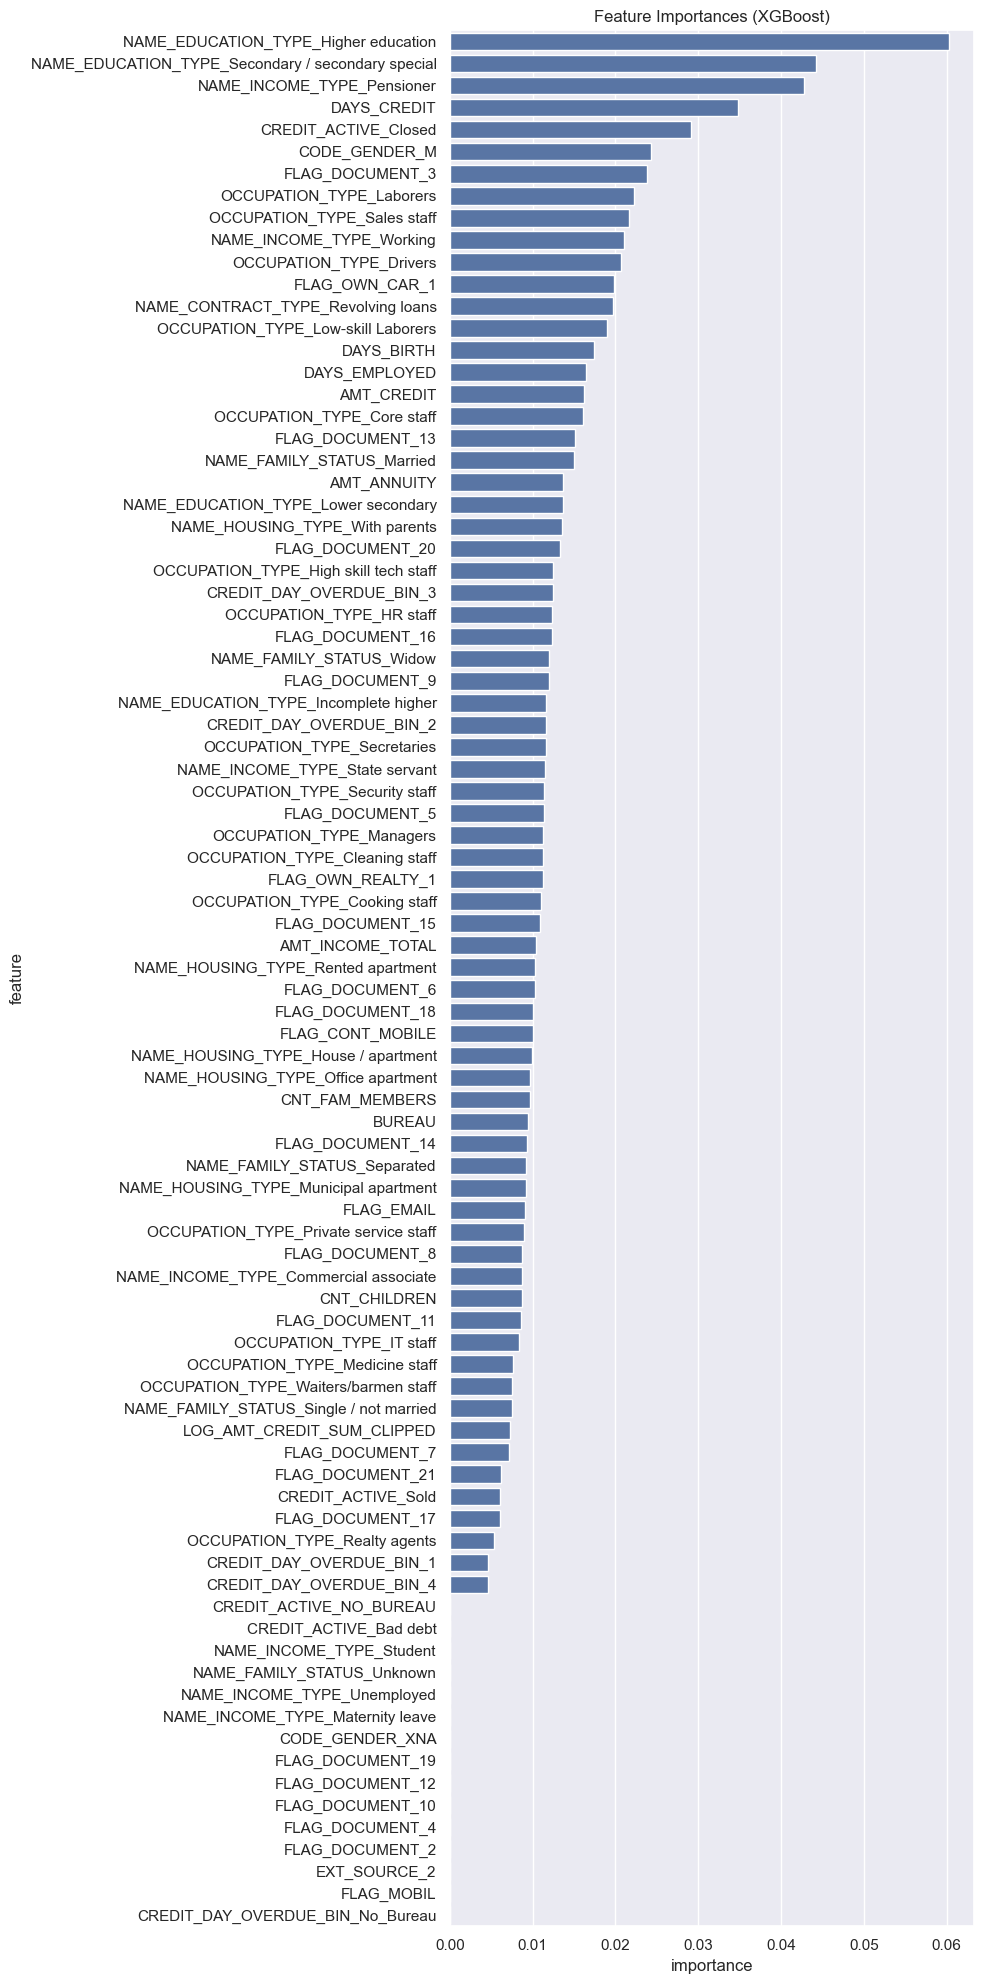

In [19]:
importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [20]:
x_train.shape

(742748, 86)

In [21]:
top = 77
top_features = importance_df['feature'].head(top).tolist()
x_train_top = x_train[top_features]
x_test_top = x_test[top_features]
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_top, y_train, test_size=0.2, random_state=42, stratify=y_train
)

2025/07/27 20:17:37 WARNING mlflow.utils.validation: Param value '[(        NAME_EDUCATION_TYPE_Higher education  \
162087                                     0   
88...' (28094 characters) is truncated to 6000 characters to meet the length limit.
c:\Users\mokon\Documents\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/07/27 20:20:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


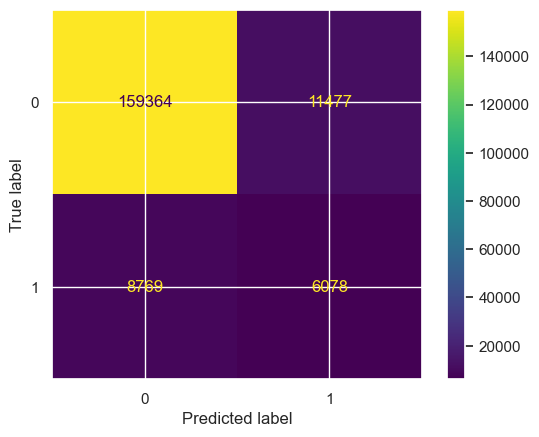

In [22]:
mlflow.end_run()
mlflow.set_experiment("xgboost-credit-default-feature-engineering")
with mlflow.start_run():
        xgb_params = {
        "n_estimators": 750,
        "max_depth": 8,
        "learning_rate": 0.02,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "scale_pos_weight": 12,
        "use_label_encoder": False,
        "eval_metric" : 'aucpr',
        "min_child_weight": 5,
        "gamma": 1,
        "reg_alpha": 0.5,
        "eval_set" : [(x_val_split, y_val_split)],
        "early_stopping_rounds":30,
        "reg_lambda": 2.0
    }
        mlflow.log_params(xgb_params)
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(
            x_train_split,
            y_train_split,
            eval_set=[(x_val_split, y_val_split)],
            verbose=False
        )
        
        y_proba = xgb_model.predict_proba(x_test_top)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx] + 0.04
        
        y_pred_opt = (y_proba > best_threshold).astype(int)
        
        report = classification_report(y_test, y_pred_opt, output_dict=True)
        mlflow.log_metric("accuracy", report["accuracy"])
        mlflow.log_metric("f1_score_class_1", report["1"]["f1-score"])
        mlflow.log_metric("recall_class_1", report["1"]["recall"])
        mlflow.log_metric("precision_class_1", report["1"]["precision"])
        
        mlflow.log_metric("best_threshold", best_threshold)
        mlflow.log_metric("f1_score_best_threshold", f1_score(y_test, y_pred_opt))
        mlflow.log_metric("precision_best_threshold", precision_score(y_test, y_pred_opt))
        mlflow.log_metric("recall_best_threshold", recall_score(y_test, y_pred_opt))
        
        cm = confusion_matrix(y_test,y_pred_opt)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        mlflow.sklearn.log_model(xgb_model, "xgb_model")

#### Saving the top features to the mlflow experiment


In [23]:
with open("top_features.pkl", "wb") as f:
    pkl.dump(top_features, f)
    
with open("cat_columns.pkl", "wb") as f:
    pkl.dump(cat_columns, f)



with mlflow.start_run(run_id = "a67db4c3f6344d3bb3862f5b78735384"):
    mlflow.log_artifact("top_features.pkl")
    mlflow.log_artifact("cat_columns.pkl")